# π-systems of hydrocarbons

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## The graphene layer

Automatic adjusting figure rows and columens!

Number of states: 18
nrows: 6
ncols: 3
HOMO-LUMO gap: 0.194


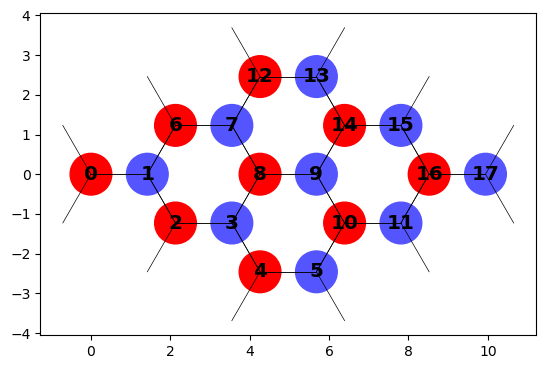

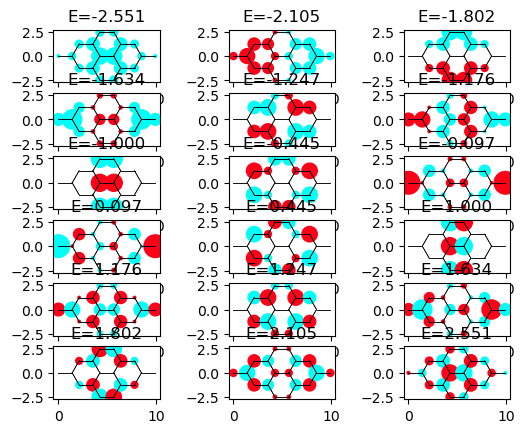

In [2]:
class Graphene:
    def __init__(self, a=1.42, n0=3, n1=3):
        ''' Initialize some parameters with some standard values
        
        Parameters
        ----
        a: bond-length (Å) (default a=1.42)
        n0: repeat tile along axis 0 (default n0=3)
        n1: repeat tile along axis 1 (default n1=3)
        
        Returns
        ----
        OBJ: object with some plotting methods.
         - Use obj.plot_neighbours() for plotting the graphene.
         - obj.choose_points() for excluding or including points in the model.
         - obj.showstates() to show the states.
         - obj.showspectrum() to show the energy spectrum.
        '''
        self.n0 = n0
        self.n1 = n1
        self.a = a
        self.xyz = np.array([[0,0,0], [self.a, 0, 0]]) # Initial positions for the two initial C (carbon) atoms.
        # self.s3 = 3**0.5 # Note used???
        self.cell = self.a / 2 * np.array([[3, -3**0.5, 0], [3, 3**0.5, 0], [0, 0, 10]]) # the size of the `cell` that should be replicated.
        
        self.mol = self.make_2D_molecule() # make the molucule 
        self._mol_copy = self.mol.copy() # make a copy for redundancy.
        
        self._points_already_choosen = False # for errorhandling in a class method.
        
        # comptutes and stores the hamiltonian, its eigenvalues, and its eigenvectors.
        self.set_hamiltonian() 
        self.es, self.vs = np.linalg.eigh(self.H)
        
        # some parameters used for sanity checks
        self._init_num_atoms = len(self.mol)
        self._init_atom_index = list(range(self._init_num_atoms))
        
        
    def _tile(self, xyz, cell, ntile=None, axis=None):
        ''' Use the tTile function that Mads Brandbyge supplied
        '''
        
        # These assertions ensures that the supplied parameters are 
        assert type(ntile) in [int, float], ValueError("`ntile` must be of type `Int` or `float`")
        assert axis is not None, ValueError("Please supply a axis (xyz-dimension).")
        
        xyz = xyz[None, ...].copy()
        xyz = xyz + cell[None, (axis,), :] * np.arange(ntile)[:, None, None]
        
        cell = cell.copy()
        cell[axis, :] *= ntile
        return xyz.reshape(-1, 3), cell
    
    def set_hamiltonian(self):
        dist = np.linalg.norm(self.mol[None, :, :] - self.mol[:, None, :], axis=2)
        self.H = np.where((dist < (self.a + 0.1)) & (dist > 0.1), -1, 0)
    
    def make_2D_molecule(self):
        txyz, tcell = self._tile(self.xyz, self.cell, self.n0, 0)
        txyz, tcell = self._tile(txyz, tcell, self.n1, 1)
        molecule = txyz[:, :2] # use only two dimensions
        return molecule
    
    def _plotneighborlines(self, ax, neighbors=None):
        reln = self.a * np.array([[2, 0], [-1, 3**0.5], [-1, -3**0.5]])/2
        for i, loc in enumerate(self.mol):
            if neighbors is None:
                dests = (-1)**i * reln + loc[None, :]
            else:
                dests = self.mol[np.flatnonzero(neighbors[i])]
            for dest in dests:
                x, y = np.vstack((loc, dest)).T
                ax.plot(x, y, "k", linewidth=0.5)
                
    
    def plot_neighbours(self, neighbours=None):
        fig, ax = plt.subplots()
        colors = ["red", "#5555FF"]*(self.n0*self.n1)  # In our case, even/odd are different sublattices
        ax.scatter(self._mol_copy[:, 0], self._mol_copy[:, 1], s=30**2, c=colors)
        for i, loc in enumerate(self._mol_copy):
            ax.text(loc[0], loc[1], str(i), verticalalignment='center', horizontalalignment="center",
                fontdict={"weight": "bold", "size": "x-large"})
        # Now the lines...
        self._plotneighborlines(ax, neighbours)
        ax.set_aspect('equal', adjustable='box')
        return fig, ax
    
    def set_mol(self, value):
        self.mol = value.copy()
        self.H 
    
    
    def choose_points(self, **index):
        ''' Use if some points should be included/excluded.
        
        Will only run once per object. If used again it will throw an error (and not change anything).
        
        Parameters
        ---
        exclude: a list of indices to exclude from the molecule.
        include: a list of indices to include in the molecule.
        
        
        '''
        
        if self._points_already_choosen:
            print("WARNING: Structure has already been edited. Overwriting previous edits.")
            # raise ValueError("This method for determining indexes can only be done once per object. This method has already been used for this object.\nIf a new `exclude` or `include` list is needed, make a new object.")
            self.set_mol(self._mol_copy)
            
        exclude = index.get("exclude", None)
        if exclude is None:
            exclude = index.get("exc", None)
        
        include = index.get("include", None)
        if include is None: 
            include = index.get("inc", None)
            
        
        indexes = list(range(len(self.mol)))
        if exclude is None:
            if include is None:
                raise AttributeError("Use either input `exclude` or `include` (or the shorthand: `exc` and `inc`). ")
            else:
                valid_index = [i for i in indexes if i in include]
        else:
            valid_index = [i for i in indexes if i not in exclude]
        
        self.mol = self._mol_copy[valid_index].copy()
        
        self.set_hamiltonian()
        self.es, self.vs = np.linalg.eigh(self.H)
        
        self._points_already_choosen = True # Gives a warning if run twice
        ### The end
        
    def showstates(self, rows_cols=None):
        '''Stolen from the handout
        
        Parameters
        ----
            rows_cols : tuple, choose the number of rows and number of columns to show the image (defaults to 3 columns and suitable rows)
        
        Returns
        ----
            fig : figure object from matplotlib.pyplot.subplots()
            ax : axes object from matplotlib.pyplot.subplots()
        '''
        if rows_cols is None:
            if (len(self.mol) > 6):
                ncols = 3
            else:
                ncols = int(len(self.mol)) // 2
            nrows = len(self.mol) / ncols
            # print(nrows)
            if (nrows % 2):
                nrows += 1
            nrows = int(nrows)
            print(f"Automatic adjusting figure rows and columens!\n\nNumber of states: {len(self.mol)}\nnrows: {nrows}\nncols: {ncols}")
            
        else:
            nrows, ncols = rows_cols
            
        
        figure, axes = plt.subplots(nrows=nrows, ncols=ncols) 
        axes = axes.flatten()
        for e, v, ax in zip(self.es, self.vs.T, axes):
            self._plotneighborlines(ax, neighbors=self.H)
            phase = np.angle(v)
            v = np.abs(v)**2 * 30**2
            ax.scatter(self.mol[:, 0], self.mol[:, 1], s=v, c=phase, cmap="hsv", vmin=-np.pi, vmax=np.pi)
            ax.set_aspect('equal', adjustable='box')
            ax.set_title(f"E={e:.3f}")
        
        ne = len(self.H) / 2
        nei = int(ne)
        if ne != nei:
            # In this case homo==lumo due to spin degeneracy
            return 0
        self.gap = self.es[nei] - self.es[nei-1]
        print(f"HOMO-LUMO gap: {self.gap:.3f}")
        
        # print(f"{type(figure) = }")
        # print(f"{type(axes) = }")
        return figure, axes
    
    def showspectrum(self):
        _, ax = plt.subplots()
        eu, neu = np.unique(self.es.round(1), return_counts=True)
        ax.bar(eu, height=neu, width=0.1)
        ax.set_ylabel("degeneracy")
        ax.set_xlabel("energy")
        ax.grid(axis="y")
            
            
        
        
        
        
benzene = Graphene()
fig, ax = benzene.plot_neighbours()
# benzene.choose_points(exclude=[0,4,5,9,10,11,12,13,14,15,16,17])
figure, axes = benzene.showstates()  
  

In [3]:

print(benzene.mol.shape)
benzene.choose_points(inc=[1,2,3,8,7,6])
print(benzene.mol.shape)
print(benzene.mol)

(18, 2)
(6, 2)
[[ 1.42        0.        ]
 [ 2.13       -1.22975607]
 [ 3.55       -1.22975607]
 [ 2.13        1.22975607]
 [ 3.55        1.22975607]
 [ 4.26        0.        ]]


In [4]:
# # Make a plot like the one in the Mathematica notebook
# f, ax = plt.subplots(figsize=(9,4))
# # First, the atoms...
# colors = ["red", "#5555FF"]*(n0*n1)  # In our case, even/odd are different sublattices
# ax.scatter(gra[:, 0], gra[:, 1], s=30**2, c=colors)
# # Then the indices...
# for i, loc in enumerate(gra):
#     ax.text(loc[0], loc[1], str(i), verticalalignment='center', horizontalalignment="center",
#             fontdict={"weight": "bold", "size": "x-large"})
# # Now the lines...
# def plotneighborlines(xyz, ax, neighbors=None):
#     reln = a * np.array([[2, 0], [-1, 3**0.5], [-1, -3**0.5]])/2
#     for i, loc in enumerate(xyz):
#         if neighbors is None:
#             # print(reln.shape)
#             # print(loc.shape)
#             dests = (-1)**i * reln + loc[None, :]
#         else:
#             dests = xyz[np.flatnonzero(neighbors[i])]
#         for dest in dests:
#             x, y = np.vstack((loc, dest)).T
#             ax.plot(x, y, "k", linewidth=0.5)
# plotneighborlines(gra, ax)
# ax.set_aspect('equal', adjustable='box')

## Function: Create hamiltonian for coordinates

In [5]:
# def hamiltonian(xyz):
#     dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
#     # print(dist)
#     # print(a)
#     return np.where((dist < (a + 0.1)) & (dist > 0.1), -1, 0)
# # Output a test
# print(hamiltonian(gra[[1, 2, 3, 8, 7, 6]]))
# # print(gra.shape)


## Function: Plot the eigenstates of a hamiltonian
Where the color is according to the phase and size according to the norm. Instead of blue/red we use a cyclic colormap (hsv, twilight, twilight_shifted exist)

Automatic adjusting figure rows and columens!

Number of states: 6
nrows: 2
ncols: 3
HOMO-LUMO gap: 2.000


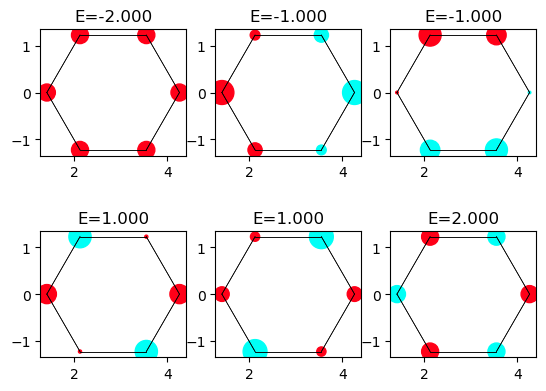

In [6]:
# def showstates(xyz):
#     H = hamiltonian(xyz)
#     vals = es, vs = np.linalg.eigh(H)
#     # print(vals)
#     # with np.printoptions(precision=3):
#     #     print("eigenvalues")
#     #     print(vs)
#     #     print()
#     if (len(xyz) > 6):
#         ncols = 3
#     else:
#         ncols = int(len(xyz)) // 2
#     nrows = len(xyz) / ncols
#     print(nrows)
#     if (nrows % 2):
#         nrows += 1
    
#     nrows = int(nrows)
        
#     print(f"len(xyz): {len(xyz)}\nnrows: {nrows}\nncols: {ncols}")
        
#     # ncols = len(xyz) // 2
#     # print(len(xyz), ncols)
#     # nrows = (len(xyz) - nrows) // 1
#     f, axes = plt.subplots(nrows, ncols)
#     axes_flattened = axes.flatten()
#     for e, v, ax in zip(es, vs.T, axes_flattened):
#         plotneighborlines(xyz, ax, neighbors=H)
#         phase = np.angle(v)
#         # with np.printoptions(precision=3):
#         #     print("iterated over transposed values")
#         #     print(v)
#         #     print()
#         v = np.abs(v)**2 * 30**2
#         ax.scatter(xyz[:, 0], xyz[:, 1], s=v, c=phase, cmap="hsv", vmin=-np.pi, vmax=np.pi)
#         ax.set_aspect('equal', adjustable='box')
#         ax.set_title(f"E={e:.3f}")
#         f.tight_layout()
#     ne = len(H) / 2
#     nei = int(ne)
#     if ne != nei:
#         # In this case homo==lumo due to spin degeneracy
#         return 0
#     gap = es[nei] - es[nei-1]
#     return gap, f
# fig, ax = plt.subplots()

# benzene.choose_points(inc=[0,1,2,3,8,7,6])
fig = benzene.showstates()
# fig.tight_layout()
# print("fig:", fig)


In [8]:
# fig = plt.subplots()

## Function: Plot the spectrum of a hamiltonian

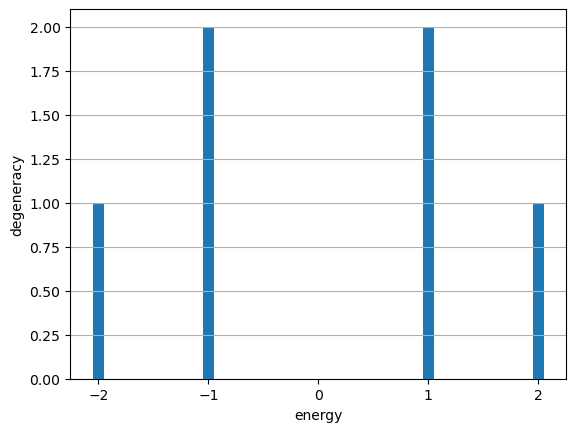

In [9]:
# def showspectrum(xyz):
#     H = hamiltonian(xyz)
#     es, vs = np.linalg.eigh(H)
#     f, ax = plt.subplots()
#     eu, neu = np.unique(es.round(1), return_counts=True)
#     ax.bar(eu, height=neu, width=0.1)
#     ax.set_ylabel("degeneracy")
#     ax.set_xlabel("energy")
#     ax.grid(axis="y")
# showspectrum(gra[[1, 2, 3, 8, 7, 6]])

benzene.showspectrum()

## Exercise : 
Try to understand the code above. Which are the HOMO and LUMO levels? What is special about the highest/lowest energy state? Which states seems to break the symmetry of the system -- how is that possible? 

Using Hund's rule for filling orbitals, and considering the geometry having degeneracy of energies $E=-1,1$ we see that  
**HOMO** level: $E=-1$  
**LUMO** level: $E=1$

## Exercise :
Consider the same for Coronene (see Fig. 5 in the notes)

Automatic adjusting figure rows and columens!

Number of states: 24
nrows: 8
ncols: 3
HOMO-LUMO gap: 1.078


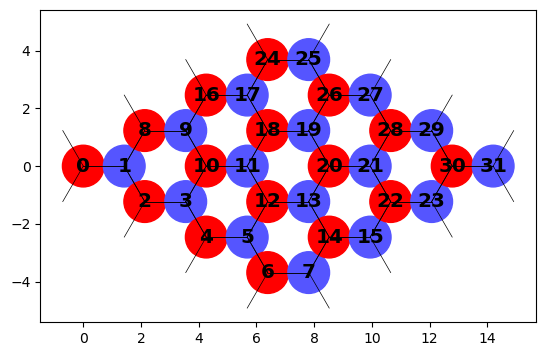

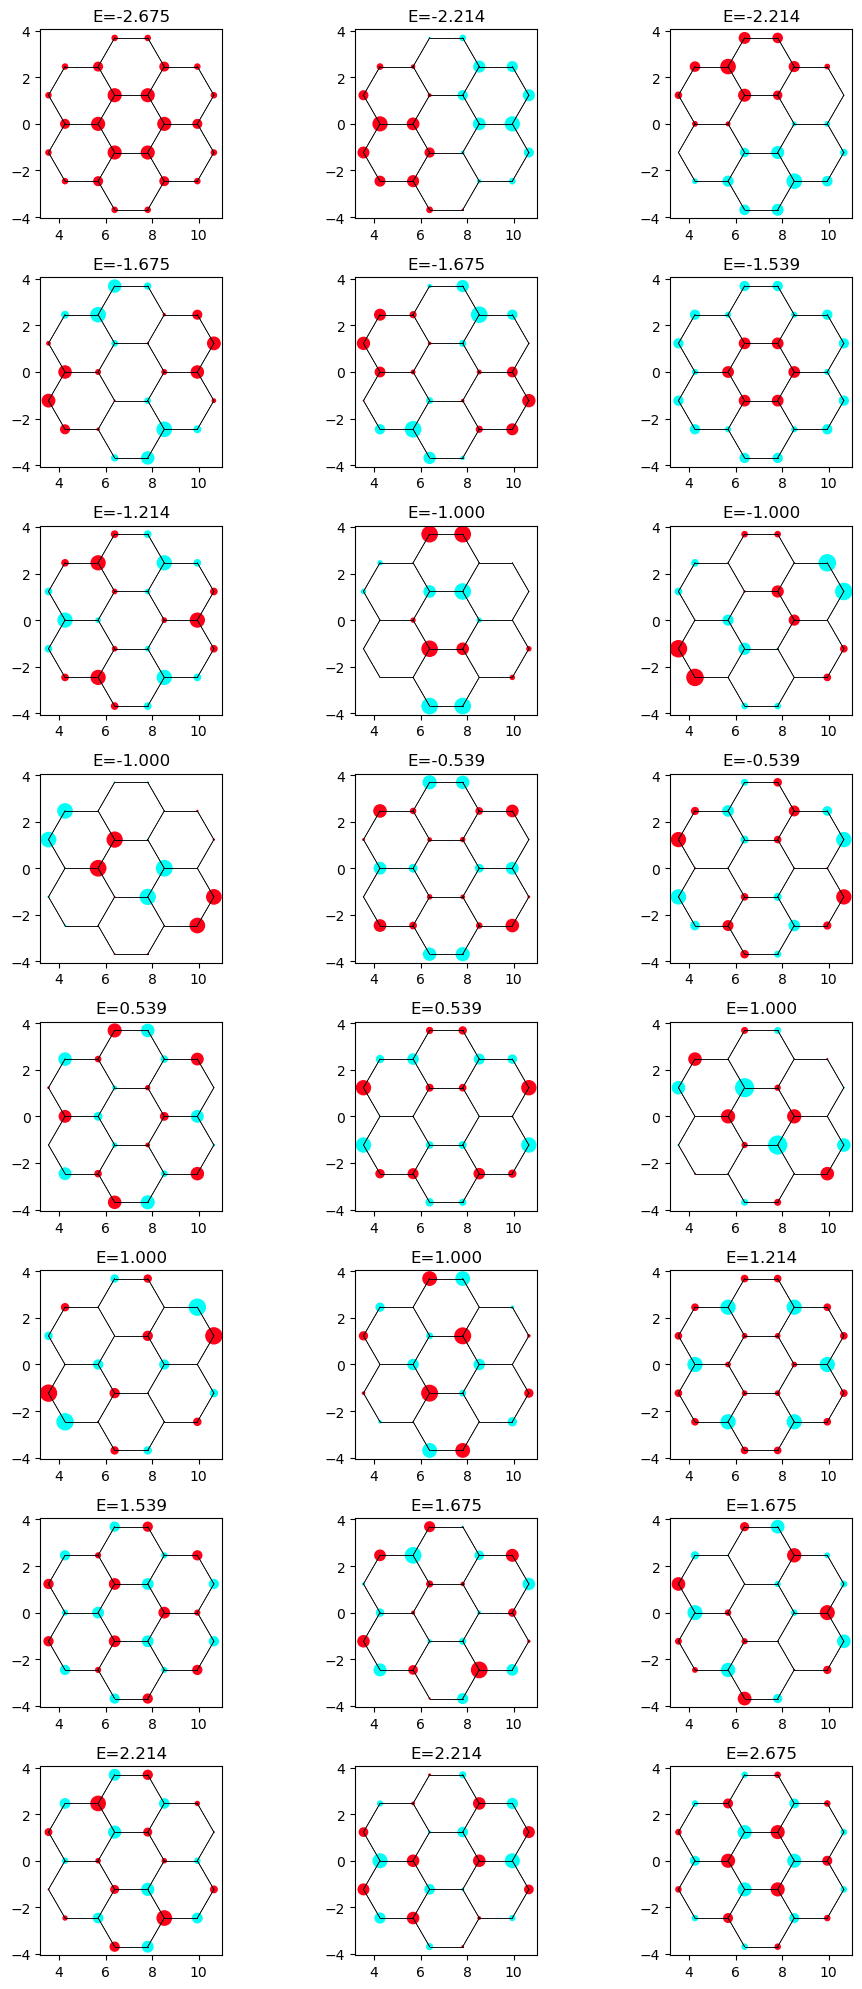

In [18]:
# class states:
#     def __init__(self, n0=3, n1=3):
#         self.n0 = n0
#         self.n1 = n1
    
#     def _tile()
    
# n2, n3 = 4, 4

# txyz_cor, tcell_cor = tile(xyz, cell, n2, 0)
# txyz_cor, tcell_cor = tile(txyz_cor, tcell_cor, n3, 1)
# cor = txyz_cor[:, :2]; cor.shape

# f, ax = plt.subplots()

# colors = ["red", "#5555FF"]*(n2*n3)  # In our case, even/odd are different sublattices
# ax.scatter(cor[:, 0], cor[:, 1], s=30**2, c=colors)
# # Then the indices...
# for i, loc in enumerate(cor):
#     ax.text(loc[0], loc[1], str(i), verticalalignment='center', horizontalalignment="center",
#             fontdict={"weight": "bold", "size": "x-large"})
    
# plotneighborlines(cor, ax)
# plt.show()

# index = list(range(32))
# do_not_include = [0,1,2,8,29,30,23,31]
# cor_index = [ind for ind in index if ind not in do_not_include]

# # print(cor[cor_index])

# gap_cor, f = showstates(cor[cor_index])
# f.set_size_inches(12,20)
# f.tight_layout()
# print(f"HOMO--LUMO gap: {gap_cor:.3f}")

coronene = Graphene(n0=4, n1=4)
coronene.plot_neighbours()
coronene.choose_points(exc=[0,1,2,8,23,29,30,31])
fig, axes = coronene.showstates();
fig.set_size_inches(10,20)
fig.tight_layout()

In [10]:
coronene.choose_points(exclude=[0,1,2,8,23,29,30,31])

Automatic adjusting figure rows and columens!

Number of states: 24
nrows: 8
ncols: 3
HOMO-LUMO gap: 1.078
type(figure) = <class 'matplotlib.figure.Figure'>


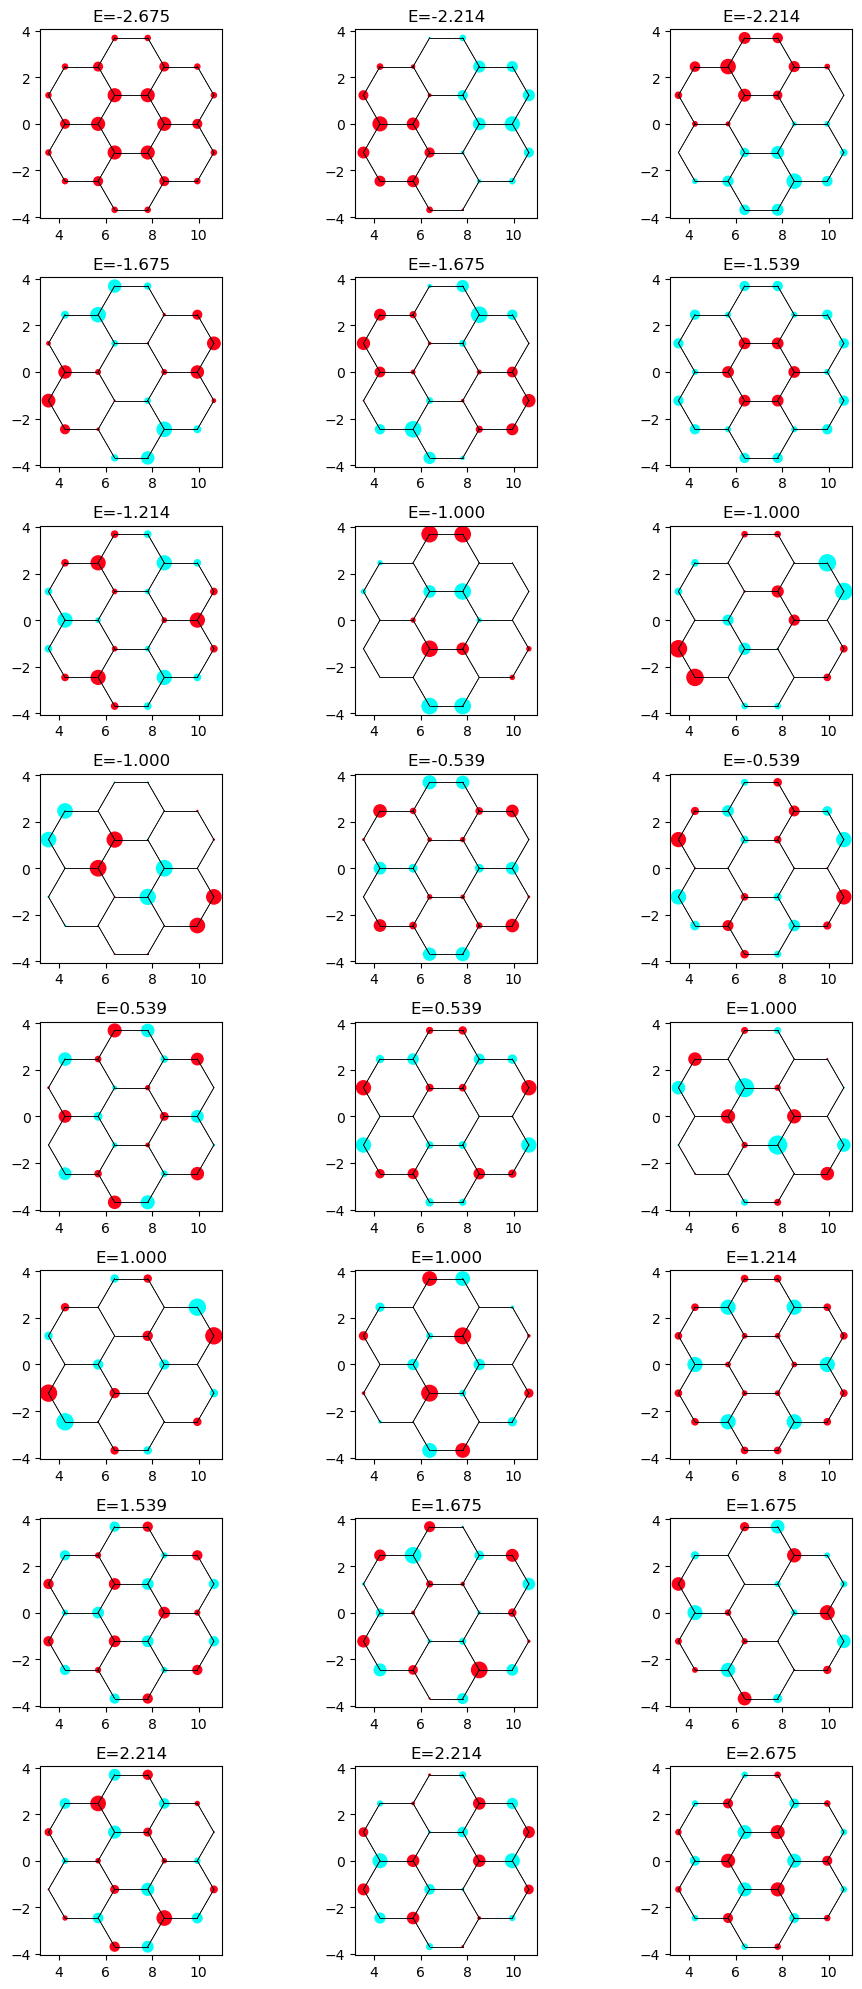

In [11]:
fig, ax = coronene.showstates()

fig.set_size_inches(10, 20)
fig.tight_layout()

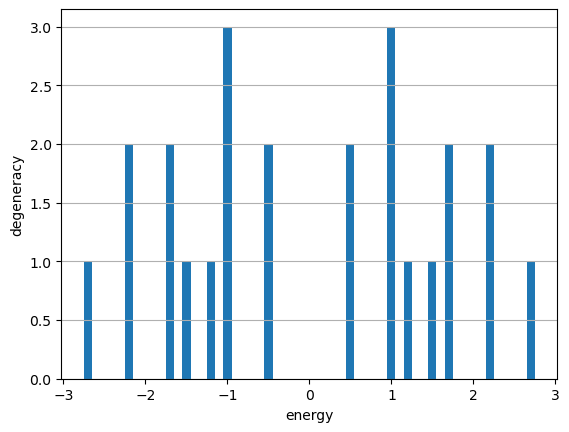

In [12]:
coronene.showspectrum()

## Exercise: 
Consider also Anthracene 

Automatic adjusting figure rows and columens!

Number of states: 14
nrows: 5
ncols: 3
HOMO-LUMO gap: 0.828
type(figure) = <class 'matplotlib.figure.Figure'>


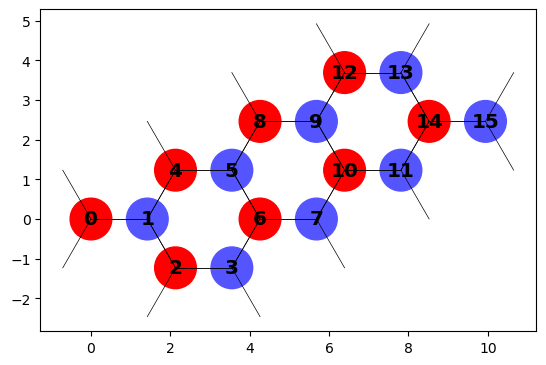

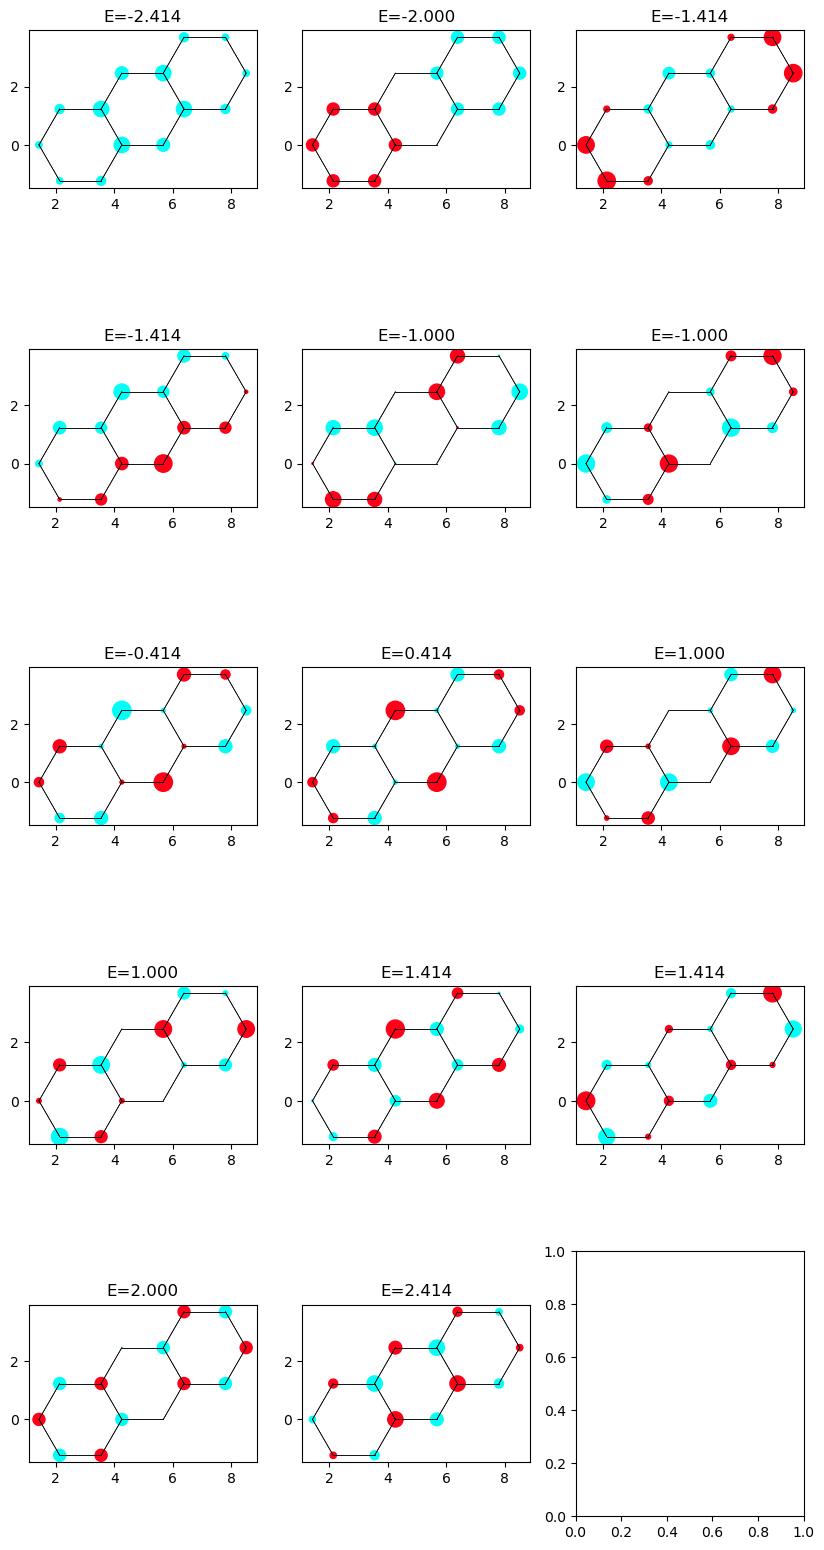

In [13]:
anthracene = Graphene(n0=2, n1=4)

anthracene.plot_neighbours()
anthracene.choose_points(exclude=[0,15])
fig, ax = anthracene.showstates()

fig.set_size_inches(10,20)
# fig.tight_layout()


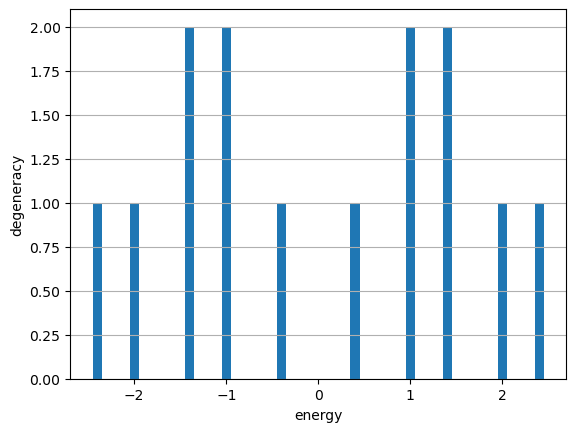

In [14]:
anthracene.showspectrum()

## Exercise: 
Is it always so that the spectrum is symmetric around E=0? Explore -- what is the relation between the state at E and -E?

The spectrum always seem to be (anti)-symmetric around energy, $E=0$. If we change one of the atoms (or simply it's energy), so they are not all equal, then the energy spectrum is not symmmetrci around $E=0$. In the examples below, it looks like the symmetry is shifted slightly.

[[ 0 -1  0 -1  0  0]
 [-1  0 -1  0  0  0]
 [ 0 -1  0  0  0 -1]
 [-1  0  0  0 -1  0]
 [ 0  0  0 -1  0 -1]
 [ 0  0 -1  0 -1  0]]


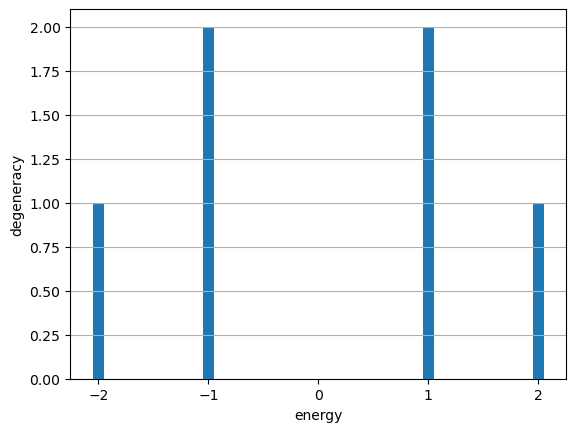

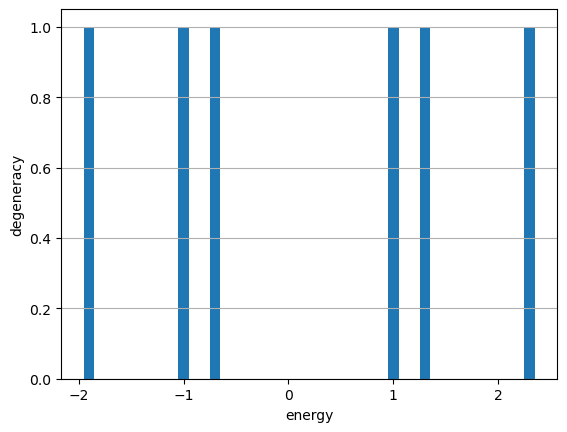

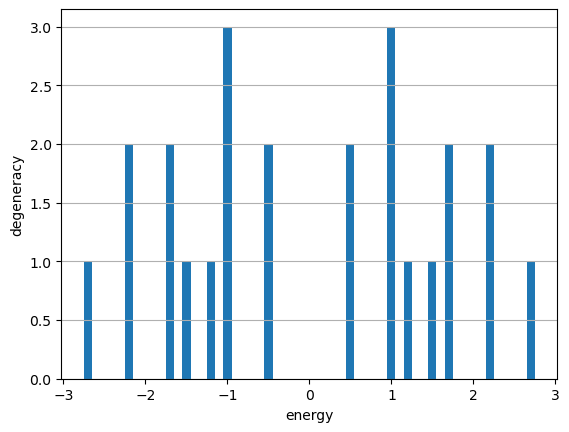

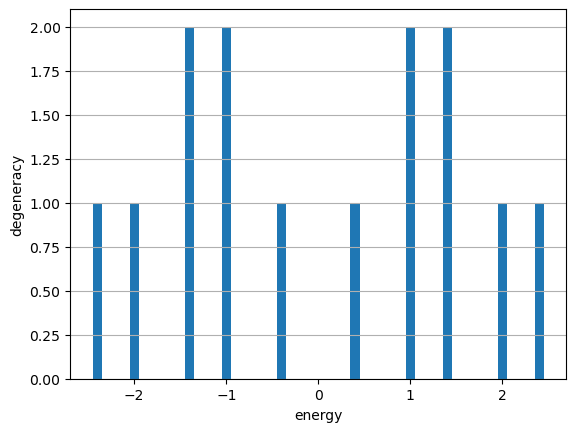

In [15]:
# benzene.mol = benzene._mol_copy
benzene.showspectrum()
print(benzene.H)
benzene.H[0,0] = 1
benzene.es, benzene.vs = np.linalg.eigh(benzene.H)
benzene.showspectrum()

coronene.showspectrum()
anthracene.showspectrum()



## What happens to the Hamiltonian if you replace the basis - set with: 
`[[1, 0, 0 ..], [0, -1, 0, 0 ..], [0, 0, 1, 0 ...], [0, 0, 0, -1] ..]` (the $\pi$-orbital on every 2nd atom is multiplied by minus one).

Automatic adjusting figure rows and columens!

Number of states: 6
nrows: 2
ncols: 3
HOMO-LUMO gap: 2.000
type(figure) = <class 'matplotlib.figure.Figure'>
[[ 0 -1  0 -1  0  0]
 [-1  0 -1  0  0  0]
 [ 0 -1  0  0  0 -1]
 [-1  0  0  0 -1  0]
 [ 0  0  0 -1  0 -1]
 [ 0  0 -1  0 -1  0]]
[[ 0.  1.  0.  1.  0.  0.]
 [-1.  0. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1.]
 [-1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  1.]
 [ 0.  0. -1.  0. -1.  0.]]
Automatic adjusting figure rows and columens!

Number of states: 6
nrows: 2
ncols: 3
HOMO-LUMO gap: 2.000
type(figure) = <class 'matplotlib.figure.Figure'>


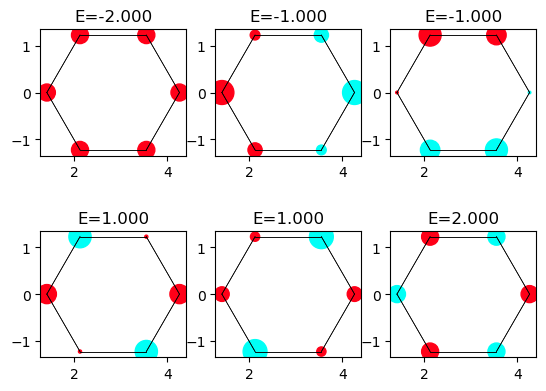

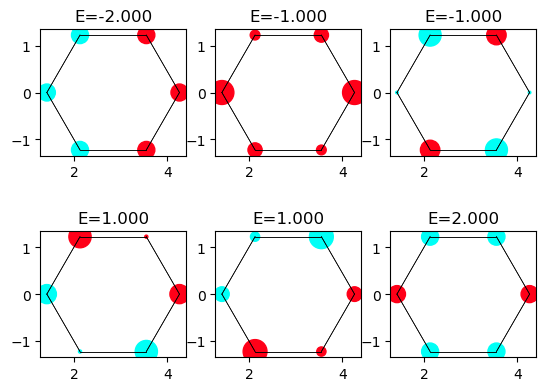

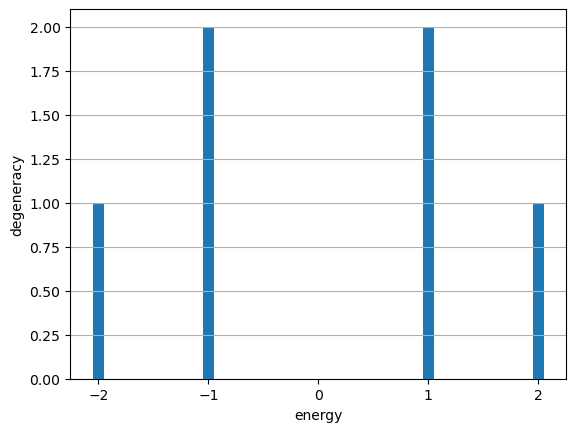

In [16]:
benz = Graphene()
# benz.plot_neighbours()
benz.choose_points(inc=[1,2,3,8,7,6])
benz.showstates()

mat = np.eye(len(benz.H))
print(benz.H)
for i in range(len(mat)):
    if i % 2:
        mat[i,i] *= -1
        
benz.H = benz.H@mat
print(benz.H)
benz.es, benz.vs = np.linalg.eigh(benz.H)
benz.showstates()
benz.showspectrum()

# Extras:

## Take a look at the Notebook "MoleculesInPython", and 
Make your code able to set up the $\pi$-electron tight-binding hamiltonian for a molecule defined from a list of C atoms either from a xyz file read-in or somewhere else and solve for the eigenvalues and eigenstates.

## Make plots (3 D) of the eigenstates (generalize the 2D plots)
Hint
```python
from mpl_toolkits.mplot3d import Axes3D
f, ax = plt.subplots(subplot_kw=dict(projection="3d"))
ax.scatter(*xyz.T)
```


## Try out your code on a C60 molecule
Would require the 3D-generalization!

## Use the ASE for plotting 3D atomic structure

https://wiki.fysik.dtu.dk/ase

Installation: https://wiki.fysik.dtu.dk/ase/install.html

In [17]:
from ase import Atoms
from ase.visualize import view # external viewer
from ase.visualize.plot import plot_atoms # view inside jupyter

In [18]:
molecule = Atoms(['C' for i in txyz],
             positions=txyz,
             cell=cell,
             pbc=[1, 1, 0])

NameError: name 'txyz' is not defined

In [ ]:
view(molecule)  # open external viewer

In [ ]:
f, a = plt.subplots(); plot_atoms(molecule, a, rotation="0x,0y,0z") # view inside jupyter

If you want to know something about something you can put a "?" in front:

In [ ]:
?plot_atoms